# Etapa 3 - Análise com PCA(Principal Component Analysis)

- O PCA (Principal Component Analysis), ou Análise de Componentes Principais, é uma técnica de redução de dimensionalidade comum em Estatística e Ciência de Dados. Seu objetivo principal é transformar um conjunto de variáveis possivelmente correlacionadas em um conjunto menor de variáveis independentes chamadas componentes principais, preservando o máximo de variância dos dados. Em resumo, O PCA reduz a dimensionalidade dos dados mantendo o máximo de informação possível, ajudando na simplificação, visualização e preparação dos dados para algoritmos de machine learning.

- Nessa etapa, o objetivo é aplicar o PCA ao problema e avaliar se o modelo mantém a capacidade de interpretar os dados, ou seja, se não há perda de informação. Caso haja perda de informação, o melhor caminho é manter os resultados gerados na etapa anterior deste projeto.  



### Carregando os Dados

In [1]:
# importando as bibliotecas
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from auxiliary_functions import elbow_silhouette_charts
from auxiliary_functions import clusters_viz
import seaborn as sns
import matplotlib.pyplot as plt

# Ajiustando parâmetros do sistema para suprimir a exibição de avisos
import warnings
warnings.filterwarnings('ignore')
import os

os.environ["OMP_NUM_THREADS"] = "1"

In [ ]:
# Definindo parâmetros do projeto
DADOS = r"../data/Mall_Customers_v02.csv"

# Importando os dados
base = pd.read_csv(DADOS)

# Visualizando a base de dados
base.head(3)

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6


### Pipeline de Pré-processamento e Clusterização

- A princípio, as diferenças de escala não são tão grandes entre as variáveis nessa base de dados, principalmente pelo fato de que a coluna que representa a renda anual está com a ordem de grandeza reduzida em 10 <sup>-3</sup>. 

- Porém, para um modelo de clusterização baseado na distância entre pontos como o K-Means, é fundamental que as escalas dos dados estejam padronizadas. 

- Além disso, os dados de todas as variáveis se distribuem de forma relativamente próxima a uma distribuição gaussiana, fazendo com que a utilização do Standard Scaler ajude a centralizar e normalizar a distribuição dos dados, já que esse método faz com que os dados tenham desvio padrão 1 e média igual a 0.

- Sendo assim, o transformador Standard Scaler foi utilizado para as variáveis numéricas e o OneHotEncoder foi utilizado para preparar a coluna categória 'Gender'

In [3]:
# Estruturando o pré-processamento
preprocessing = ColumnTransformer(
    [
        ('standard', StandardScaler(), ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']),
        ('ohe', OneHotEncoder(), ['Gender'])
    ]
)

In [4]:
# Criando um novo dataframe com os dados transformados
base_scaled= pd.DataFrame(
    preprocessing.fit_transform(base),
    columns=preprocessing.get_feature_names_out(),
)

- Avaliando o gráfico Elbow method, a primeira quebra forte no gráfico aparece com n = 4, seguida de uma leve quebra em n=5. Avaliando o Silhouette method, tem-se também em n-=4 um máximo local, praticamente nivelado com n=5.

- Considerando o gráfico pairplot da Etapa 1, onde já houve um indicativo de 5 clusters, além dos resultados dos gráficos Elbow e Silhouette, o número de clusters escolhido é 5.

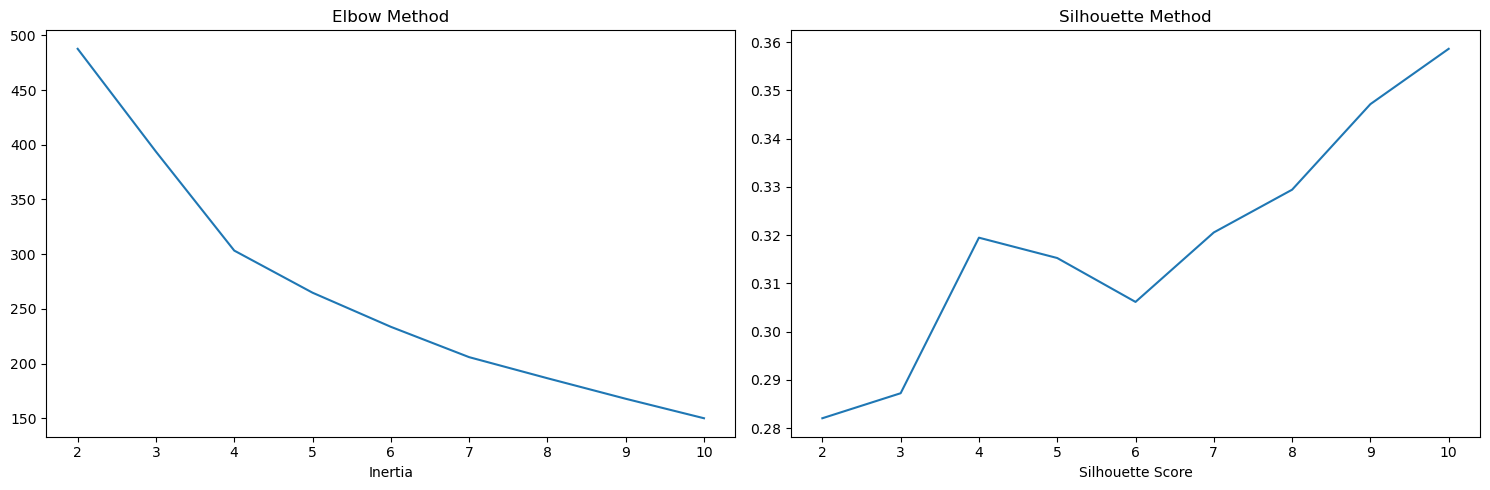

In [5]:
# Plotando os gráficos para Elbow e Silhouette methods
elbow_silhouette_charts(base_scaled)

- Em seguida, foi definido um pipeline de etapas de transformação dos dados para realizar o pré-processamento, a redução de dimensionalidade com o PCA e a clusterização.

In [6]:
# Criando o pipeline de etapas para a clusterização
pipeline = Pipeline(
    [
        ('preprocessing', preprocessing),
        ('pca', PCA(n_components=3)),
        ('clustering', KMeans(n_clusters=5, random_state=42, n_init=10))
    ]
)

pipeline.fit(base)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('standard', StandardScaler(),
                                                  ['Age', 'Annual Income (k$)',
                                                   'Spending Score (1-100)']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['Gender'])])),
                ('pca', PCA(n_components=3)),
                ('clustering',
                 KMeans(n_clusters=5, n_init=10, random_state=42))])

In [7]:
# Exportando o modelo
import joblib

joblib.dump(pipeline, "../models/pca_clustering.pkl")

['../models/pca_clustering.pkl']

In [8]:
# Criando um novo dataframe com a informação dos clusters
base_clustered = base.copy()
base_clustered['cluster'] = pipeline['clustering'].labels_
base_clustered.head(3)

,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,Male,19,15,39,1
1,Male,21,15,81,3
2,Female,20,16,6,1


- Abaixo segue o número de clientes por cluster, que acabada sendo relativamente próximo para todos os grupos, o que é um indicativo de que o número de grupos definido como 5 foi uma boa escolha.

In [9]:
# Visaulizando o número de clientes por cluster
base_clustered['cluster'].value_counts().sort_index()

cluster
0    58
1    47
2    34
3    22
4    39
Name: count, dtype: int64

- A correlação das variáveis foi avaliada em pares com o gráfico de pairplot, evidenciando cada um dos clusters conforme legenda. Para essa análise, o objetivo é entender, com os gráficos de dispersão, como cada par de variáveis se relaciona com a divisão dos clusters. 

- Os gráficos mostrados na diagonal principal da figura ilustram a distribuição dos dados para cada uma das variávies do problema, também evidenciando o comportamento de cada cluster conforme legenda.

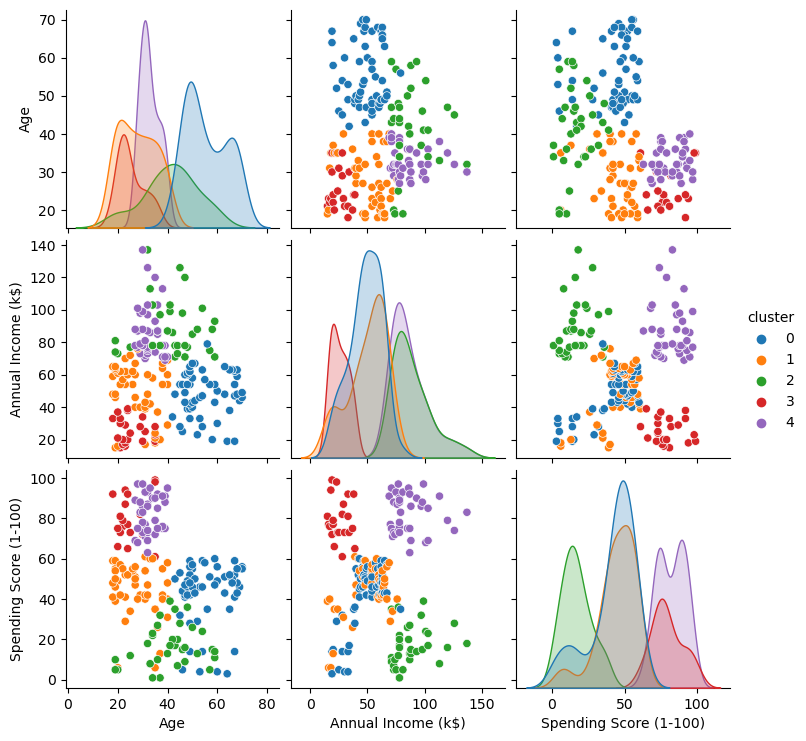

In [10]:
# Avaliando a correlação das variáveis
sns.pairplot(base_clustered, diag_kind = 'kde', hue='cluster', palette='tab10');

- Por fim, foram utilizados gráficos de boxplot para avaliar tanto a distribuição estatítica dos dados dentro de cada cluster como a existência de outliers.

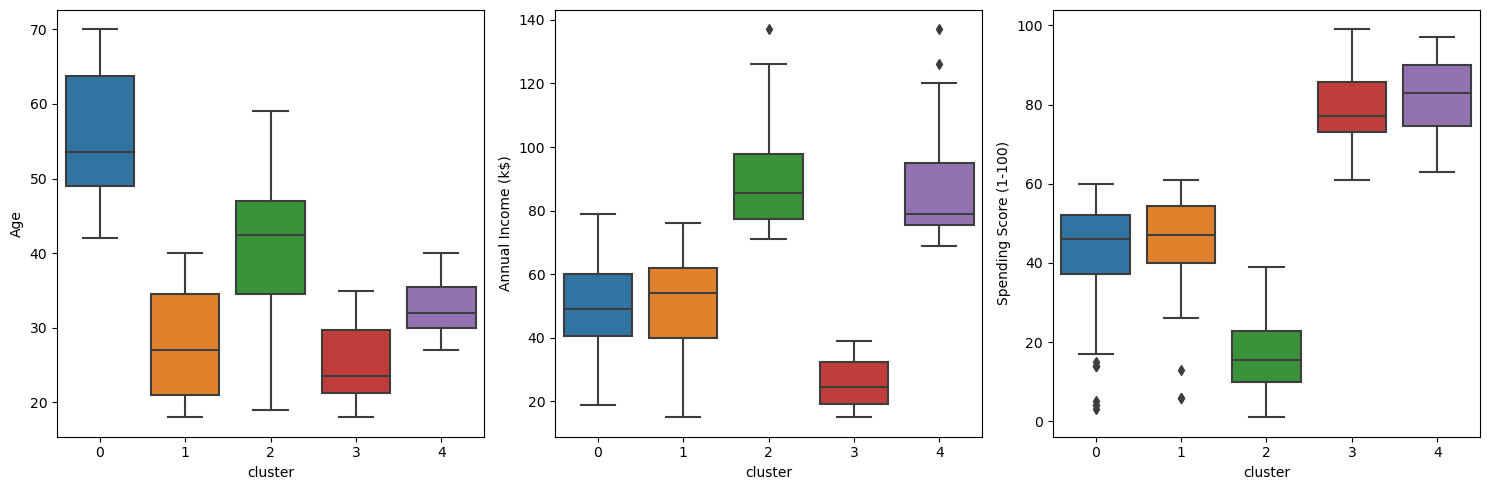

In [11]:
# Visualizando a distribuição estatística dos dados por cluster através de boxplots
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5), tight_layout = True)

for ax, col in zip(axs, base_clustered.select_dtypes('number')):
    sns.boxplot(data = base_clustered, x = 'cluster', y=col, ax=ax)

plt.show()

In [12]:
# Criando uma nova base de dados com o 
base_pca = pd.DataFrame(
    pipeline[:-1].fit_transform(base),
    columns=pipeline[:-1].get_feature_names_out()
)

- Com o objetivo de tangibilizar a vizualização dos clusters, foi criado um gráfico em 3d desconsiderando a variável categórica 'Gender'.

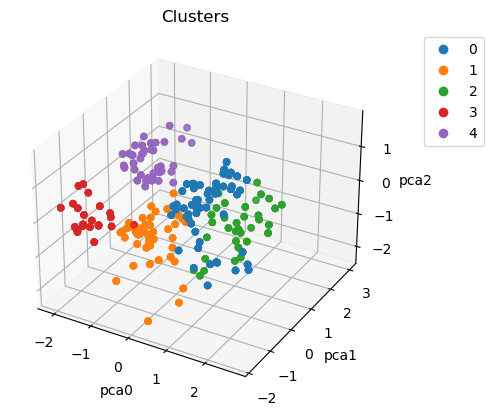

In [13]:
# Descomente a linha abaixo para obter gráficos iterativos
#%matplotlib ipympl

clusters_viz(
    base_pca,
    colunas=['pca0', 'pca1', 'pca2'],
    quantidade_cores = 5,
    centroids=pipeline['clustering'].cluster_centers_,
    mostrar_pontos=True,
    mostrar_centroids=False,
    coluna_clusters=base_clustered['cluster']  
)

In [14]:
# Avaliando a performance do modelo com PCA
print('Porcentagem de variância dos que o modelo consegue explicar: {:.2f} %'.format(pipeline['pca'].explained_variance_ratio_.sum()*100))

Porcentagem de variância dos que o modelo consegue explicar: 86.10 %


### Conclusão

- Após a redução da dimensionalidade da base de dados, o modelo foi capaz de explicar 86,10% da variância dos dados, ou seja, pode-se dizer que após o PCA cerca de 14% de informação foi perdida. Para uma base enxuta como essa, qualquer perda de informação acaba sendo relevante, dado que o custo computacional da clusterização com todas as dimensões é muit baixo. Por isso, optou-se por manter a seguimentação realizada na Etapa 2 sem a aplicação do PCA.  